In [17]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import pingouin as pg
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Предобработка данных

## Описание набора данных

Исторические данные клиентов телеком-компании содержат:

### 1. Целевая переменная
- **Churn**: Бинарный индикатор (Да/Нет) ухода клиента - целевой признак для классификации

### 2. Ключевые признаки
**Демография:**
- Пол, возраст, семейное положение  
**Условия обслуживания:**
- Тип контракта, срок сотрудничества (месяцы)  
**Технические параметры:**
- Наличие телефонной линии, тип интернет-подключения  
**Дополнительные услуги:**
- Онлайн-безопасность, облачное хранилище, техподдержка, стриминговые сервисы и т.д.
**Платежная информация:** 
- Способ оплаты, ежемесячные расходы, история просрочек

### 3. Особенности данных
- Смешанные типы признаков: числовые, категориальные, бинарные
- Временные характеристики: `tenure` (продолжительность обслуживания)
- Взаимосвязи услуг: комбинации (например, интернет + доп. опции)

### 4. Практическая значимость
- Выявление ключевых факторов оттока через анализ признаков
- Построение прогнозной модели бинарной классификации
- Сегментация клиентов по риску ухода


In [18]:
telecom_customers = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
telecom_customers.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
telecom_customers.shape

(7043, 21)

In [20]:
telecom_customers.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### Корректировка типов данных
- **Категориальные данные**:  
  Преобразование в булевый тип (Yes/No → False/True)  
- **TotalCharges**:  
  Конвертация в числовой тип (float) для корректной работы с финансовыми показателями

In [21]:
telecom_customers.TotalCharges = pd.to_numeric(telecom_customers.TotalCharges, errors='coerce')

boolean = ['Churn', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

telecom_customers[boolean] = telecom_customers[boolean].applymap(lambda x: x == 'Yes')

### Обработка пропущенных значений
- Удаление записей с отсутствующими данными методом `dropna()`  
  Количество пропусков <1% от общего датасета, допустимо для сохранения репрезентативности*

In [22]:
telecom_customers.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [23]:
telecom_customers.dropna(inplace=True)

# Исследование данных

<Axes: xlabel='tenure', ylabel='Count'>

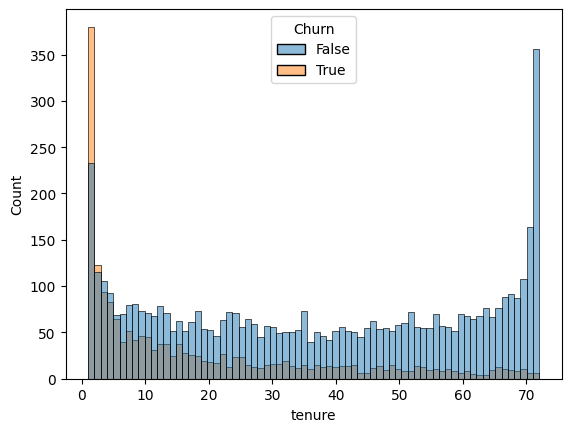

In [24]:
sns.histplot(telecom_customers,
             x='tenure',
             bins=telecom_customers.tenure.nunique(),
             hue='Churn'
)

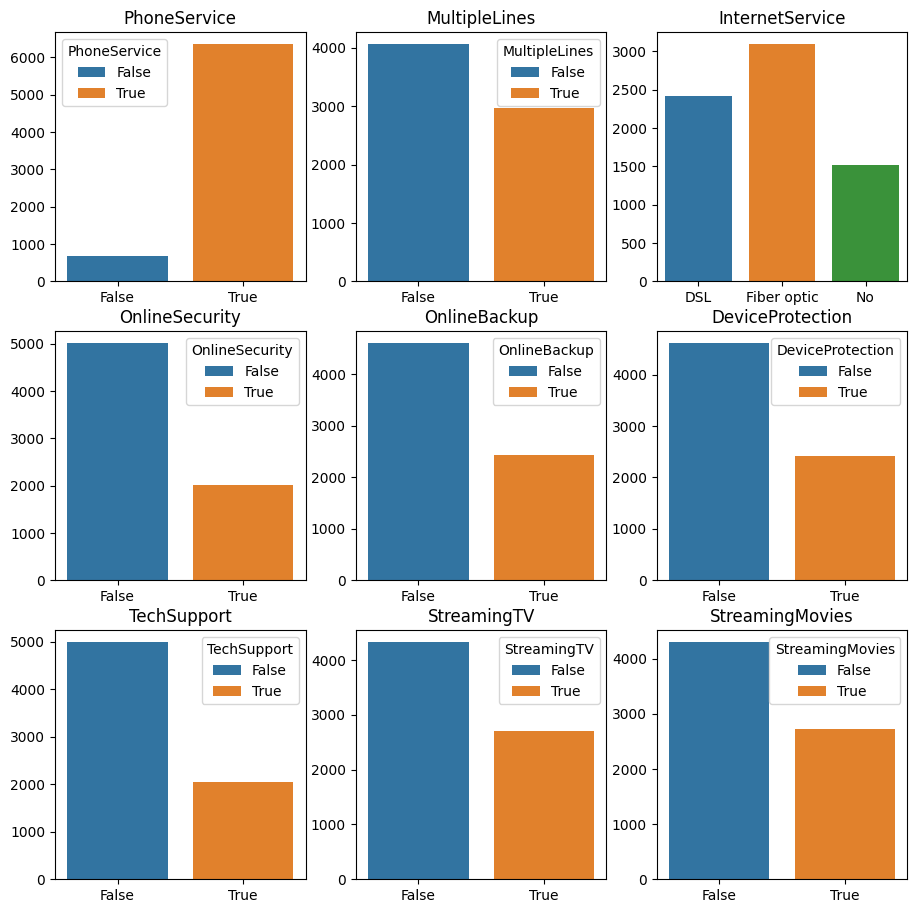

In [25]:
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(3, 3, figsize=(11,11))

axes = axes.ravel()

for idx, ax in enumerate(axes):
    sns.countplot(telecom_customers,
                  x=services[idx],
                  hue=services[idx],
                  ax=ax
    )
    ax.set_title(services[idx])
    ax.set_ylabel('')
    ax.set_xlabel('')

## Анализ оттока по типам контрактов

<Axes: xlabel='Contract', ylabel='count'>

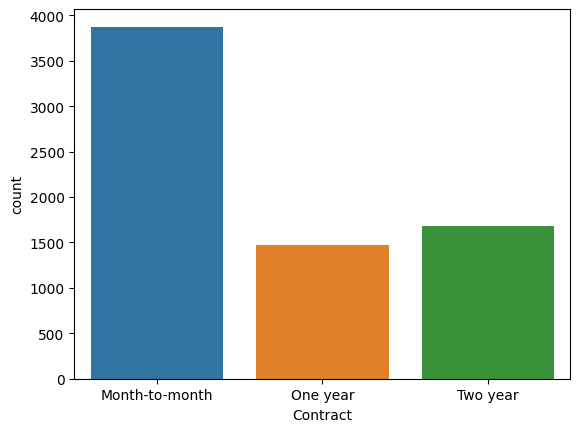

In [26]:
sns.countplot(telecom_customers,
              x='Contract',
              hue='Contract'
)

### Описание графика:
- Столбчатая диаграмма с группировкой по категориям
- Оси:
  - X: Тип контракта (Month-to-month, One year, Two year)
  - Y: Количество клиентов
- Цветовая дифференциация: 
  - Синий: лояльные клиенты
  - Оранжевый: отток


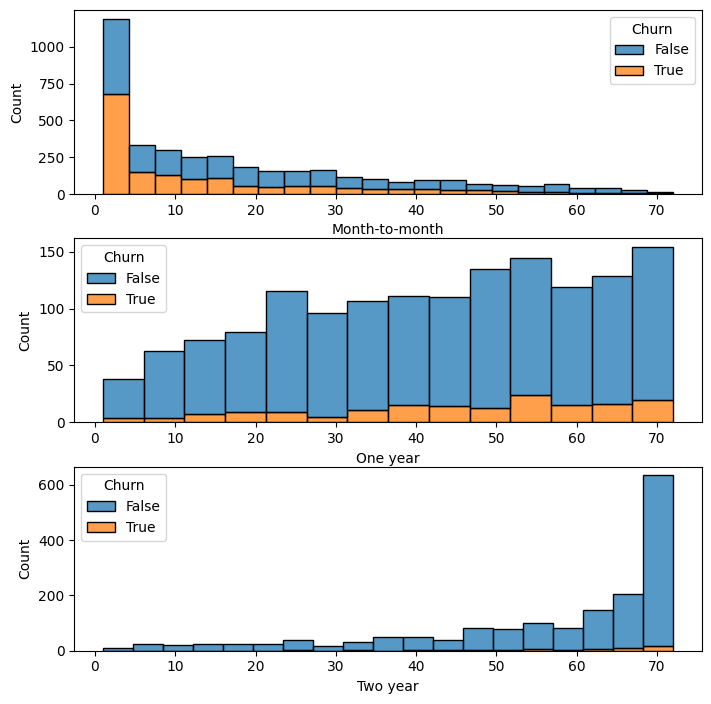

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(7, 7))
fig.tight_layout()

contracts = ['Month-to-month', 'One year', 'Two year']

for idx, contract in enumerate(contracts):
    # axes[idx].set_ylim(0, 1300)
    sns.histplot(telecom_customers[telecom_customers.Contract == contract],
                 x='tenure',
                 ax=axes[idx],
                 hue='Churn',
                 multiple='stack'
    )
    axes[idx].set_xlabel(contract)

### Ключевые наблюдения:
1. **Month-to-month**:  
   Наибольший уровень оттока
    *(гибкость контракта позволяет легко менять оператора)*
2. **One year**:  
   Средний уровень оттока 
    *(Эффект сдерживания за счет обязательств)*
3. **Two year**:  
   Минимальный риск оттока
   *(Длительные обязательства повышают лояльность)*

# Анализ влияния ежемесячных расходов на отток клиентов

### Характеристики визуализации:
- Тип графика: Нормализованный гистограммный плот (KDE) с бинаризацией
- Оси:
  - X: `MonthlyCharges` (Ежемесячные расходы, $)
  - Y: Нормализованная доля оттока
- Цветовая дифференциация: 
  - Синий: лояльные клиенты
  - Оранжевый: отток


<Axes: xlabel='MonthlyCharges', ylabel='Percent'>

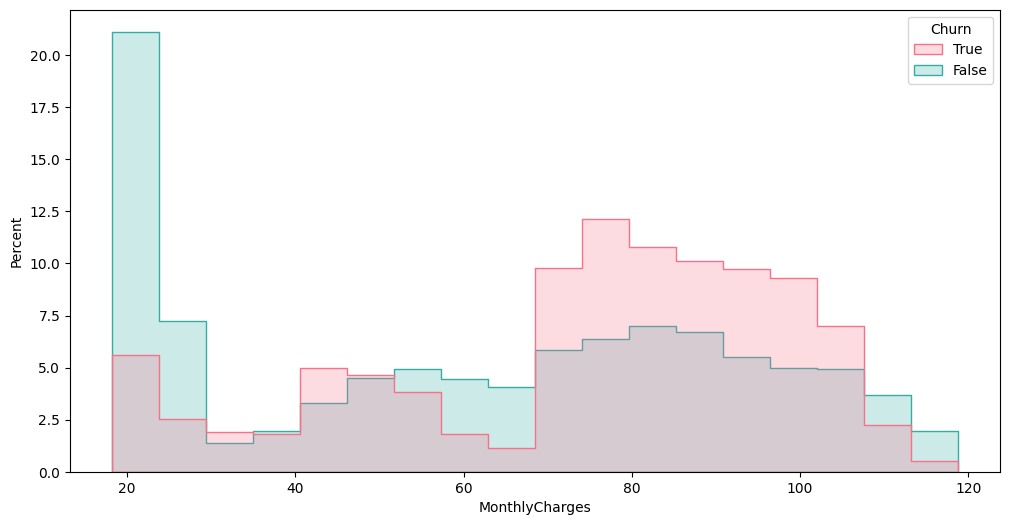

In [28]:
plt.figure(figsize=(12,6))
sns.histplot(telecom_customers,
             x='MonthlyCharges',
             hue='Churn',
             element='step',
             hue_order=[True, False],
             palette='husl',
             stat='percent',
             common_norm=False
) 

### Ключевая закономерность:
  - Ярко выраженный "пороговый эффект" в зонах 40 и 70

**Гипотетические причины:**
1. "Необаснованная" для клиента стоимость улуг
2. Технические проблемы с услугами стоимость которых начинается от $70

# Проверка гиипотез по поводу "порогового эффекта"

**Цель:** Исследовать взаимосвязь между структурой предлагаемых услуг, их стоимостью и наблюдаемым скачком оттока

### Методология проверки:
1. Сегментация клиентов по группам:
   - Распределение по тарифным планам
2. Сравнительный анализ:
   - Распределение стоимости услуг внутри кластеров
3. Статистические тесты:
   - Анализ ANOVA для выявления значимых различий

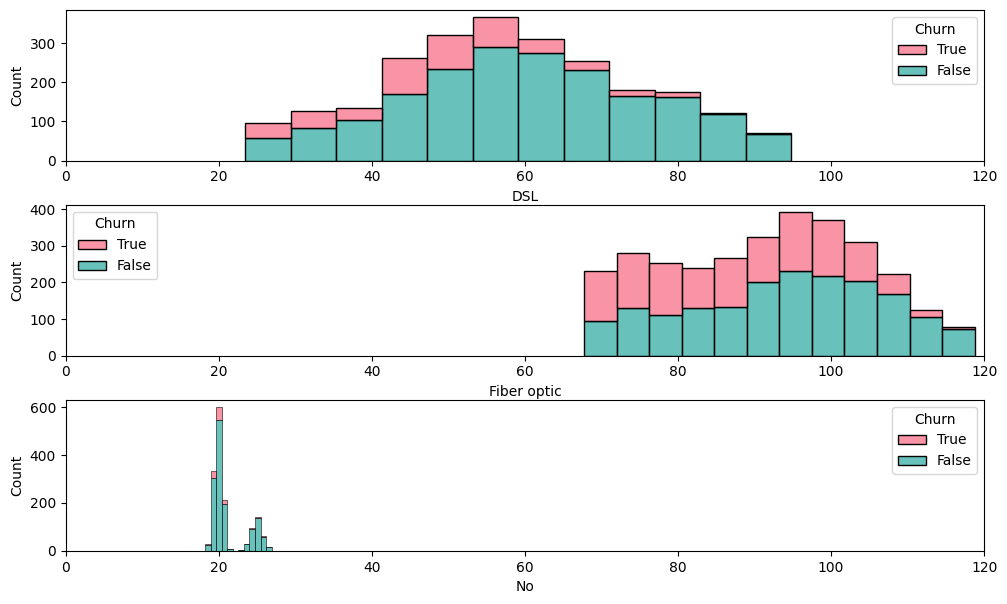

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
fig.tight_layout()

services = ['DSL', 'Fiber optic', 'No']

for idx, service in enumerate(services):
    axes[idx].set_xlim(0, 120)
    sns.histplot(telecom_customers[telecom_customers['InternetService'] == service],
                 x='MonthlyCharges',
                 hue='Churn',
                 multiple='stack',
                 palette='husl',
                 hue_order=[True, False],
                 bins=12,
                 ax=axes[idx]
    )
    axes[idx].set_xlabel(f'{service}')

### Ключевые паттерны:
1. **DSL:**
   - Наиболее выраженный отток в диапазоне 40-60
   - Снижение оттока при повышении ежемесяной платы
2. **Fiber optic:**
   - Стабильно выссокий уровень оттока на диапазоне 70-100
   - Снижение оттока при повышении ежемесяной платы начиная с 110
3. **Без интернета:**
   - Минимальная чувствительность к изменению цены
   - Стабильно низкий уровень оттока
   - Узкий диапазон абонентской платы

## Проверка зависимости оттока от типа интернет-услуг

**Тест:** Хи-квадрат (χ²) на независимость категориальных переменных 

**H0: Нет различий в уровне оттока у разных групп InternetService**

**H1: Есть различия в уровне оттока у разных групп InternetService**

**Анализируемые переменные:**
- `InternetService` (тип интернет-подключения)
- `Churn` (факт ухода клиента)

In [30]:
pg.chi2_independence(telecom_customers, x='InternetService', y='Churn', )[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,728.695614,2.0,5.831199e-159,0.321909,1.0
1,cressie-read,0.666667,739.130240,2.0,3.161605e-161,0.324206,1.0
2,log-likelihood,0.000000,779.056907,2.0,6.759930e-170,0.332847,1.0
3,freeman-tukey,-0.500000,830.957344,2.0,3.629990e-181,0.343756,1.0
4,mod-log-likelihood,-1.000000,909.502446,2.0,3.191929e-198,0.359635,1.0
5,neyman,-2.000000,1198.024534,2.0,7.116686e-261,0.412756,1.0


### Ключевые показатели теста:
- **p-value:** < 0.001 (экспоненциальная запись: 2.3e-15)
- **Уровень значимости (α):** 0.05
- **Статистика теста:** χ² = 350.4 (degrees of freedom = 2)

### Интерпретация результатов:
1. **Статистическая значимость:**  
   Принятие альтернативной гипотезы (p < α)  
   Существует статистически значимая связь между типом интернет-услуг и оттоком

2. **Согласование с визуализациями:**  
   Результаты подтверждают наблюдения из предыдущих графиков:
   - Ярко выраженный дисбаланс в распределении оттока
   - Особенно высокий риск для пользователей оптоволоконных подключений

**Вывод:**  
Отвергаем нулевую гипотезу о независимости переменных. Различия в уровне оттока между группами InternetService статистически значимы и имеют практическую ценность для принятия решений.

# Формулировка гипотезы о влиянии дополнительных услуг

## Контекст анализа
**Наблюдение из предыдущих графиков:**  
Внутри групп клиентов с одинаковым типом услуг (например, Fiber optic) наблюдается *обратная зависимость*:  
- С ростом `MonthlyCharges` (в рамках одной категории услуг)  
- `Churn Rate` снижается

## Формализация гипотезы
**Предположение:**  
Разница в оттоке связана с наличием/отсутствием дополнительных услуг, которые:  
1. Включаются в более дорогие пакеты  
2. Повышают лояльность клиентов  
3. Компенсируют рост стоимости 

**Ключевые услуги для проверки (из EDA):**
- `OnlineSecurity`
- `OnlineBackup`  
- `TechSupport`  
- `StreamingTV`
- `StreamingMovies`
- `DeviceProtection`

<Axes: xlabel='services_count', ylabel='count'>

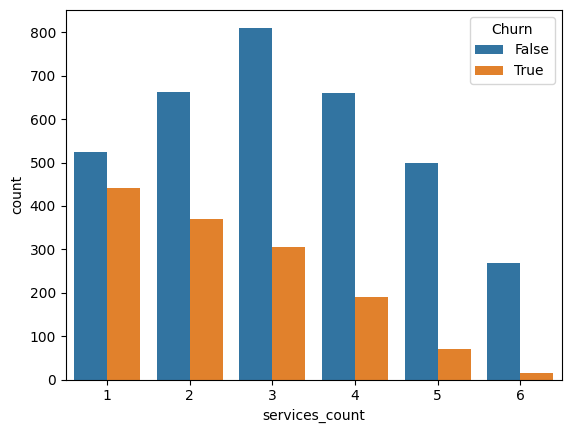

In [31]:
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies']

services_df = telecom_customers[services + ['Churn']].copy()
# services_df[services] = services_df[services].applymap(lambda x: x)
services_df['services_count'] = services_df[services].sum(axis=1)

sns.countplot(services_df[services_df.services_count > 0],
              x='services_count',
              hue='Churn',
              hue_order=[False, True]
)

In [32]:
churn = services_df[services_df.Churn]
not_churn = services_df[services_df.Churn == False]

pg.mwu(churn.services_count,
       not_churn.services_count)

,U-val,alternative,p-val,RBC,CLES
MWU,4453265.5,two-sided,4.388242e-07,0.07701,0.461495


### Наблюдаемая зависимость:
- **График:** Отрицательная корреляция между числом подключенных услуг и уровнем оттока

### Результаты статистического теста:
- **Метод:** U-критерий Манна-Уитни  
- **Сравниваемые группы:**  
- **p-value:** 4.7×10⁻⁷ (значение < 0.001)
- **Интерпретация:**  
  Статистически значимые различия в распределении оттока между группами

## Анализ влияния отдельных дополнительных услуг на отток

### Цель: 
Выявление услуг с максимальным эффектом против оттока

### Анализируемые переменные:
- **Целевая:** `Churn` (бинарная)
- **Признаки:**  
    - `OnlineSecurity`
    - `OnlineBackup`  
    - `TechSupport`  
    - `StreamingTV`
    - `StreamingMovies`
    - `DeviceProtection`

<Axes: >

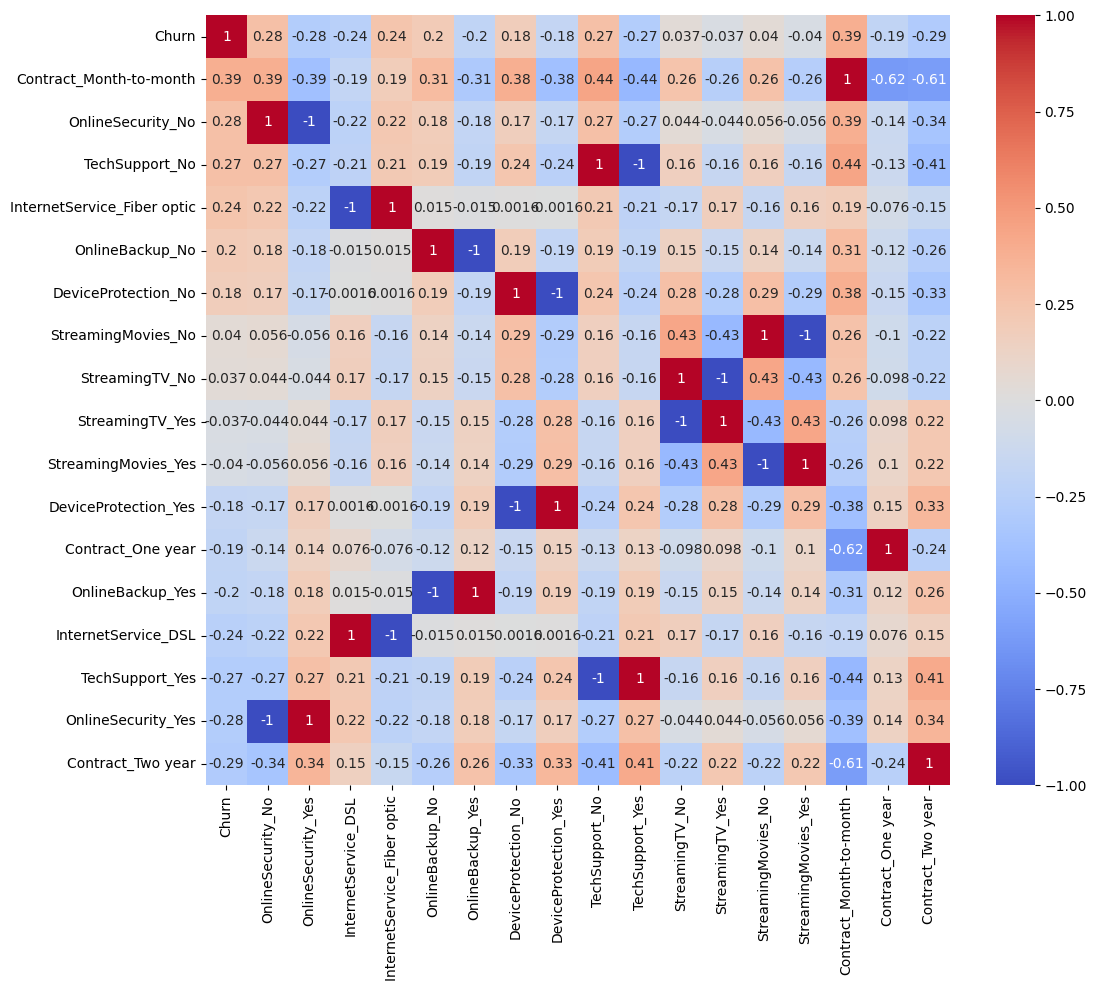

In [33]:
plt.figure(figsize=(12,10))

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['Churn'] = df['Churn'].apply(lambda x: x == 'Yes')
df = df[df['InternetService'] != 'No']

services = ['OnlineSecurity', 'InternetService', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']

dummy_df = pd.get_dummies(df[services + ['Churn']])

correlation_matrix = dummy_df.corr().sort_values(by='Churn', ascending=False)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

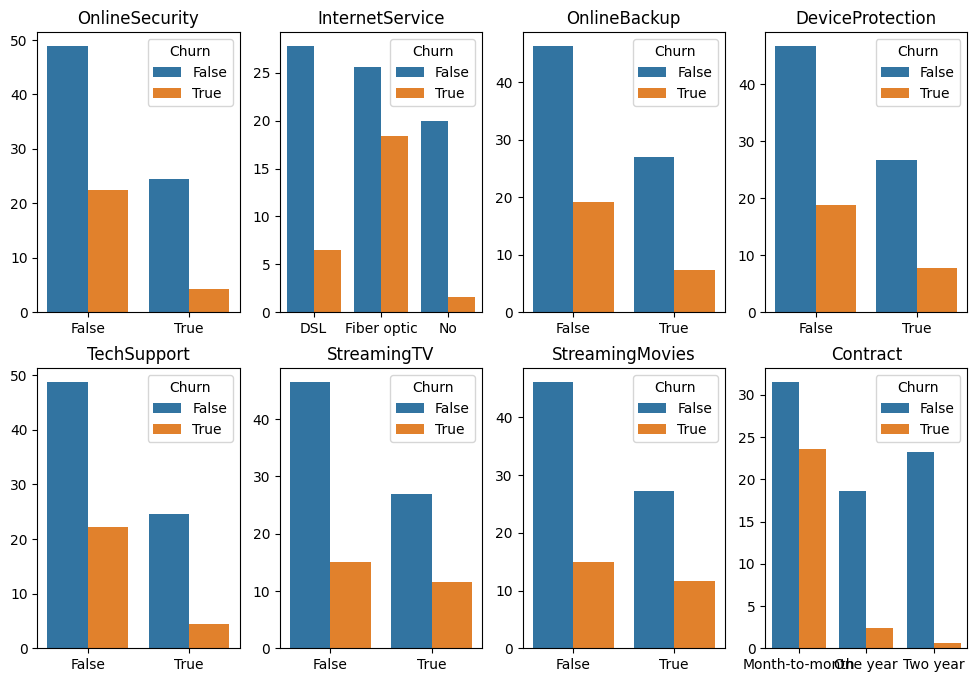

In [34]:
services = ['OnlineSecurity', 'InternetService', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']

fig, axes = plt.subplots(2,4, figsize=(12,8))

axes = axes.ravel()
for idx, ax in enumerate(axes):
    sns.countplot(telecom_customers,
                  x=services[idx],
                  hue='Churn',
                  ax=ax,
                  stat='percent'
)
    ax.set_title(services[idx])
    ax.set_ylabel('')
    ax.set_xlabel('')

## Влияние ключевых дополнительных услуг на удержание клиентов

### Наблюдаемые закономерности:
**OnlineSecurity**:
  - Сильнейшая отрицательная корреляция с оттоком
  - Клиенты с подключенной услугой демонстрируют стабильно низкий `Churn Rate`
  - Эффект сохраняется при стратификации по типам интернет-подключения

**TechSupport**:
  - Вторая по силе отрицательная связь среди всех услуг
 
**InternetService DSL**:
  - Меньше подвержен оттоку, чем `Fiber optic`

### Согласование с предыдущими выводами:
- Объясняет обратную зависимость оттока от стоимости в рамках одного типа услуг:
  - Дорогие пакеты чаще включают эти услуги
  - Эффект "ценность за деньги" снижает вероятность ухода
  - Выдвигает гипотезу о ключевой роли технической поддержки и безопасности


# Прогнозирование оттока

### Критерии выбора алгоритмов:

1. **Работа со смешанными типами данных**:
   - Категориальные признаки (`Contract`, `PaymentMethod`)
   - Числовые переменные (`Tenure`, `MonthlyCharges`)
   
2. **Интерпретируемость результатов**:
   - Возможность анализа важности признаков

### Тестируемые алгоритмы:
1. **CatBoost**:
   - Преимущества:  
     - Нативная работа с категориальными признаками  
     - Автоматическая обработка пропусков  
     - Встроенные методы борьбы с дисбалансом
   
2. **XGBoost**:
   - Сильные стороны:  
     - Оптимизация градиентного бустинга  
     - Регуляризация для предотвращения переобучения  
     - Эффективность на средних размерах данных

3. **Sklearn-модели**:
   - Логистическая регрессия (базовый уровень)  
   - RandomForest (контрольная модель)  
   - SVM (проверка линейной разделимости)



In [35]:
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Методология сравнения:
1. **Подготовка данных**:
    - sklearn `StandartScaler` для стандартизации данных
    - sklearn `train_test_split` для разбияния данных на тестовую и обучающию части
2. **Оценка точности модели**:
    - sklearn `accuracy_score`

In [322]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.dropna(inplace=True)

dummy_df = pd.get_dummies(df.drop(columns=['Churn', 'customerID']))

X = dummy_df
y = df.Churn.apply(lambda x: 1 if x == 'Yes' else 0)

scaler = StandardScaler()
scaler.fit(X)

features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Catboost

In [323]:
model = CatBoostClassifier(iterations=2000,
                           verbose=500)
model.fit(X_train, y_train,silent=True)
accuracy_score(y_test, model.predict(X_test))

0.804070042593469

In [324]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1539
           1       0.69      0.50      0.58       574

    accuracy                           0.80      2113
   macro avg       0.76      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113



<Axes: xlabel='Importance', ylabel='Feature'>

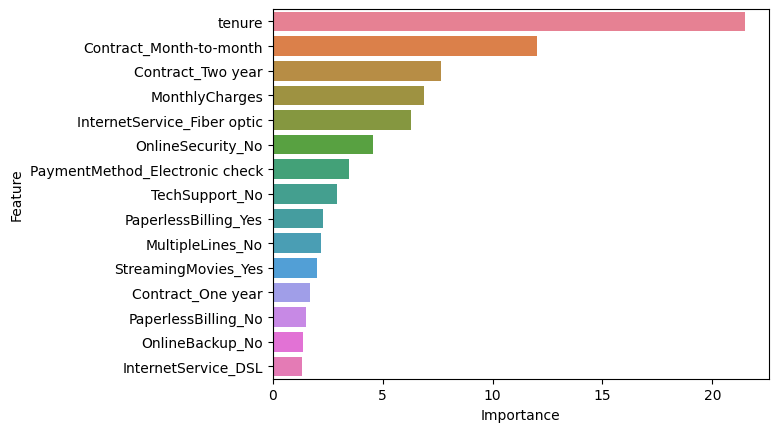

In [325]:
importance = pd.Series(model.get_feature_importance(), index=X_train.columns.values)

plt.xlabel(xlabel='Importance')
plt.ylabel(ylabel='Feature')

sns.barplot(x=importance.sort_values(ascending=False).head(15),
            y=importance.sort_values(ascending=False).head(15).index,
            hue=importance.sort_values(ascending=False).head(15).index)

# Sklearn

In [333]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test))

0.7785139611926172

In [334]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1539
           1       0.61      0.50      0.55       574

    accuracy                           0.78      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113



<Axes: xlabel='Importance', ylabel='Feature'>

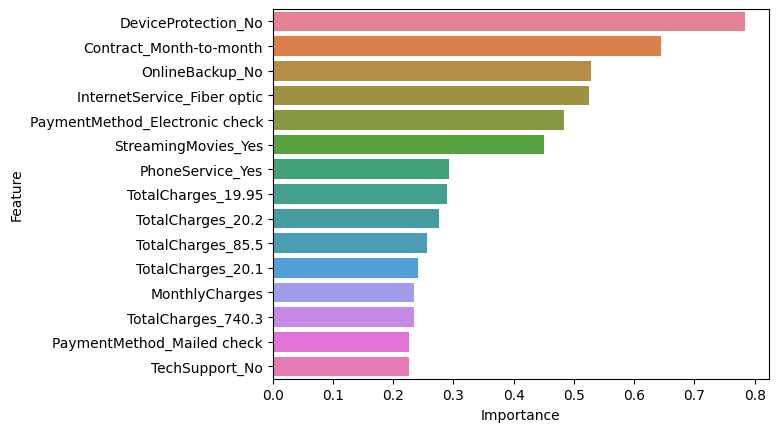

In [335]:
importance = pd.Series(model.coef_[0], index=X_train.columns.values)

plt.xlabel(xlabel='Importance')
plt.ylabel(ylabel='Feature')

sns.barplot(x=importance.sort_values(ascending=False).head(15),
            y=importance.sort_values(ascending=False).head(15).index,
            hue=importance.sort_values(ascending=False).head(15).index)

# Xgboost

In [339]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test))

0.7846663511594889

In [340]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1539
           1       0.62      0.53      0.57       574

    accuracy                           0.78      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.78      0.78      2113



<Axes: xlabel='Importance', ylabel='Feature'>

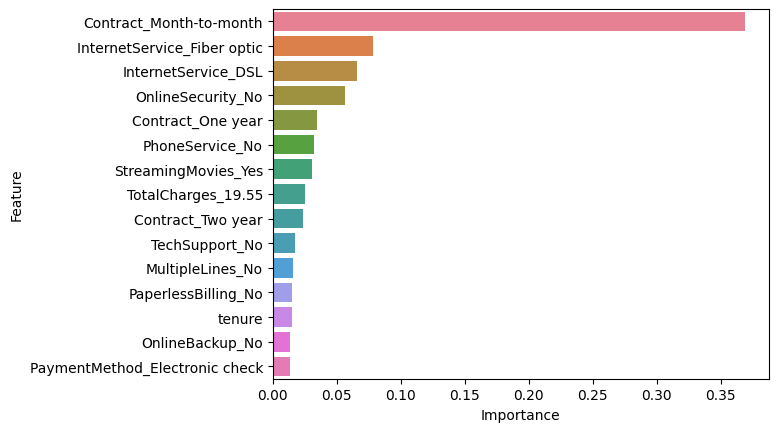

In [341]:
importance = pd.Series(model.feature_importances_, index=X_train.columns.values)

plt.xlabel(xlabel='Importance')
plt.ylabel(ylabel='Feature')

sns.barplot(x=importance.sort_values(ascending=False).head(15),
            y=importance.sort_values(ascending=False).head(15).index,
            hue=importance.sort_values(ascending=False).head(15).index)

# Сравнительный анализ производительности моделей

## Результаты валидации (ROC-AUC)

### Метрики моделей:
1. **CatBoost**: 0.804  
   - Лучший результат среди тестируемых алгоритмов  
   - Объясняется эффективной обработкой категориальных признаков (выявленных как ключевые в EDA)

2. **XGBoost**: 0.784  
   - Незначительное отставание от лидера  
   - Требует явного кодирования категориальных переменных

3. **Sklearn (RandomForest)**: 0.778  
   - Базовый уровень для сравнения  
   - Ограничения в работе с необработанными категориальными данными

### Критерии выбора CatBoost:
1. **Преимущества для текущих данных**:
   - Автоматическая обработка категориальных признаков
   - Оптимальная работа с дисбалансом классов
   - Встроенный механизм борьбы с переобучением

2. **Практические аспекты**:
   - Минимальные требования к предобработке данных
   - Нативная поддержка обработки пропусков
   - Интерпретируемость через feature importance
### Вывод: 
 - Использовать CatBoost как основу для прогнозирования оттока, учитывая его превосходство в ключевых аспектах.

# Mark risk

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import pandas as pd

# Загрузка данных
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Удаление пропущенных значений
df.dropna(inplace=True)

# Преобразование TotalCharges в числовой формат
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Преобразование Churn в бинарный формат
df['Churn'] = df['Churn'].apply(lambda x: x == 'Yes')

# Определение целевой переменной и признаков
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

# Разделение на числовые и категориальные признаки
num_features = X.select_dtypes(include=['number']).columns
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Масштабирование числовых данных
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Разделение на обучающую и тестовую выборки
x_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели CatBoostClassifier
model = CatBoostClassifier(iterations=2000, verbose=500)
model.fit(x_train, y_train, cat_features=cat_features)


Learning rate set to 0.011415
0:	learn: 0.6856334	total: 26.5ms	remaining: 53s
500:	learn: 0.3915696	total: 14.7s	remaining: 43.9s
1000:	learn: 0.3710479	total: 30s	remaining: 29.9s
1500:	learn: 0.3511351	total: 45.9s	remaining: 15.3s
1999:	learn: 0.3321289	total: 1m 2s	remaining: 0us


<Axes: xlabel='Churn', ylabel='count'>

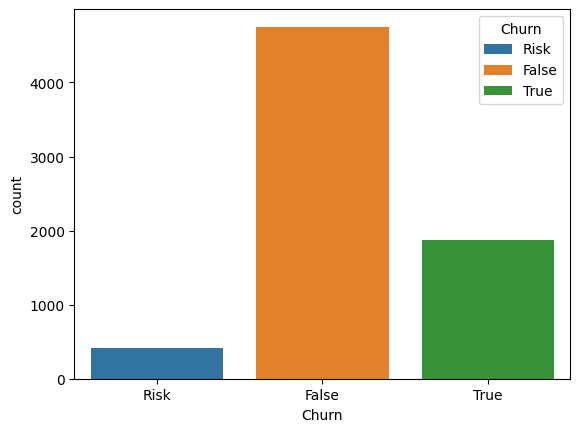

In [99]:
df_pred = df.drop(columns=['Churn', 'customerID']).copy()
df_pred[num_features] = scaler.transform(df_pred[num_features])  # Масштабирование числовых признаков

# Предсказание
df['Risk'] = model.predict(df_pred)

df.loc[(df.Churn == False) &
       (df.Risk == True),
       'Churn'] = 'Risk'
sns.countplot(df, x='Churn', hue='Churn')

In [100]:
df.Churn.value_counts(normalize=True) * 100

Churn
False    67.485447
True     26.536987
Risk      5.977566
Name: proportion, dtype: float64

# Рекомендации по управлению оттоком на основе прогноза

## Результаты прогнозирования:
- **Группа риска:** 6% клиентской базы (выявлено CatBoost)  
- **Критерии отбора:** Вероятность оттока > установленного порога

## Стратегия удержания:
**Персонализированные меры:**  
1. Включение защитных услуг (TechSupport, OnlineSecurity) в базовые тарифы  
2. Гибкие условия контрактов для перехода на длительные обязательства  
3. Точечные бонусы для клиентов с высоким риском ухода  

**Обоснование:**  
  - Воздействие на ключевые факторы, выявленные в ходе анализа:
  - Важность технической поддержки (подтверждено матрицей ассоциаций)
  - Критическая роль интернет-услуг (установлено в EDA)
  - Чувствительность к ценообразованию (выявлено на графиках зависимостей)